In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import itertools

## Conways game of life

The [game of life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is a zero-player game where the point is to set the initial game state and watch the following three rules take effect over many interations.

1. Any live cell with two or three neighbors survives.
2. Any dead cell with three live neighbors becomes a live cell.
3. All other live cells die in the next generation. Similarly, all other dead cells stay dead.

Or I guess this can be written as:

1. Any cell with three neighbours becomes a live cell
2. Any live cell with two neighbors survives
3. All others die or stay dead.

Each cell is a pixel on a 2D orthogonal grid, so a random small 5x5 world could be represented in a numpy array like this:

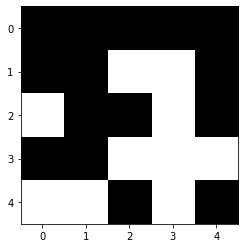

In [2]:
np.random.seed(0) #set seed for reproducible result
plt.imshow(np.random.uniform(size= (5,5))>.75, cmap = "gray");

All white cells in this grid are considered "alive". The idea of the game of life is to consider at each timestep wether or not a cell will be alive in the next timestep based on the rules outlined above. Lets first implement this in a most basic way.

We have to:
1. Initialize a world of size _cols_ and _rows_
2. Iterate over all cells
3. Check all neighbours for all cells
4. Decide if a cell lives or dies
5. Have the new state returned.

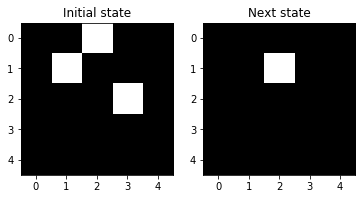

In [3]:
#Initializing and showing the world
cols = 5
rows = 5
world = np.random.uniform(size = (cols, rows)) > .7

#sneak-start on 5: a place to store the next state
next_state = np.empty_like(world)

#2 iterate over all cells
width, height = world.shape
for x, y in itertools.product(range(width), range(height)):
    #3 check all neighbours for all cells:
    neighbours = 0
    for i, j in itertools.product([-1,0,1],[-1,0,1]):
        #make sure we dont see the current cell as neighbor as well:
        if i != 0 or j != 0:
            xi = (x+i + rows)%rows #the adding of rows and taking the modulus deals with the edges
            yj = (y+j + cols)%cols
            neighbours += world[xi, yj]
    #4 decide if cell [x,y] lives or dies:
    #rule one: if three live neighbors the cell lives
    if neighbours == 3:
        next_state[x,y] = 1
    #rule two: If alive and two neighbours, the cell survives
    elif neighbours == 2 and world[x,y] == 1:
        next_state[x,y] = 1
    #rule three: The rest dies.
    else:
        next_state[x,y] = 0
        
#5, next state:
fig, axes = plt.subplots(1,2)
axes[0].imshow(world, cmap = "gray")
axes[0].set_title("Initial state")
axes[1].imshow(next_state, cmap = "gray")
axes[1].set_title("Next state");

That seems correct! Now lets put things neatly in a function so we can iterate and play the game:

In [107]:
def game_of_life(world):
    next_state = np.empty_like(world)
    width, height = world.shape
    for x, y in itertools.product(range(width), range(height)):
        neighbours = 0
        for i, j in itertools.product([-1,0,1],[-1,0,1]):
            if i != 0 or j != 0:
                xi = (x+i + width)%width
                yj = (y+j + height)%height
                neighbours += world[xi, yj]
        if neighbours == 3:
            next_state[x,y] = 1
        elif neighbours == 2 and world[x,y] == 1:
            next_state[x,y] = 1
        else:
            next_state[x,y] = 0
    return next_state

Now we can initialize a new world and calculate 10 generations to see if our game works.

In [100]:
world = np.random.uniform(size = (rows,cols)) > 0.8
generations = [game_of_life(world)]
for i in range(10):
    generations.append(game_of_life(generations[-1]))

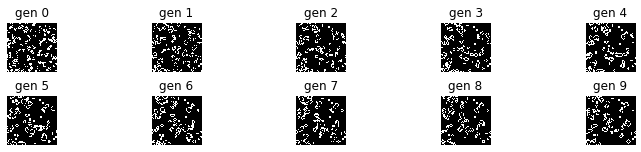

In [101]:
fig, axes = plt.subplots(2,5, constrained_layout= True, figsize = (10, 2))
for ax, gen in zip(axes.ravel(), generations):
    ax.imshow(gen, cmap = "gray")
    ax.axis("off")
    ax.set_title(f"gen {list(axes.ravel()).index(ax)}")

We have generations! Now we need to figure out animations because this way of visualizing it is no fun at all. Be right back, have to read some documentation...

It seems that for the basic matplotlib animation I will have to rethink the structure of the way of life a bit. It iterates the animate function, so I have to make sure that it overwrites the world variable at the end of every iteration so that it is ready for the next one.

In [102]:
rows = 50
cols = 50
fig, ax = plt.subplots(figsize = (6,6))
img = ax.imshow(np.zeros(shape = (rows, cols)), cmap = "gray")
global world
world = np.random.uniform(size = (rows, cols)) > .4

#init function for the animation returns empty world
def init_func():
    img.set_array(np.zeros(shape = (rows, cols)))
    return img,


def animate(i):
    global world
    world = game_of_life(world)
    img.set_array(world)
    img.autoscale()
    return img,
    
game = animation.FuncAnimation(fig, animate, init_func = init_func, blit = True, interval = 100, frames = 200);
plt.close(game._fig);
HTML(game.to_jshtml())

In [79]:
#save to gif if you want.
game.save("./game.gif", writer = "imagemagick")

This is working nicely! On to the next important step:

## Optimizing

The `game_of_life` function works, but is really quite slow. It is essentially a 4-deep nested for-loop, and if we want to run the game of life on larger worlds calculating new timesteps will take a long time. In a worlf of 1000 by 1000 cells for example:

In [103]:
world = np.random.uniform(size = (1000,1000))

In [108]:
%timeit game_of_life(world)

5.23 s ± 280 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On my machine it takes ~5 seconds to calculate a single iteration of a larger world. This is not really usable if we want to quickly make animations. Fortunately, there is [numba](https://numba.pydata.org/) which I think can make a lot of difference for us here. Numba is a package that compiles python into efficient machine code at runtime and this can really speed up the parts where python is inherently slow, like in loops.

For this to work I have to get rid of the `itertools.product` that I find so elegant to write nested loops with, since numba does not seem to like it. This is the code optimized with numba.

In [109]:
from numba import njit
@njit
def game_of_life_jit(world):
    next_state = np.empty_like(world)
    width, height = world.shape
    for x in range(width):
        for y in range(height):
            neighbours = 0
            for i in [-1,0,1]:
                for j in [-1,0,1]:
                    if i != 0 or j != 0:
                        xi = (x+i + width)%width
                        yj = (y+j + height)%height
                        neighbours += world[xi, yj]
                if neighbours == 3:
                    next_state[x,y] = 1
                elif neighbours == 2 and world[x,y] == 1:
                    next_state[x,y] = 1
                else:
                    next_state[x,y] = 0
    return next_state

Lets see what te gains are:

In [110]:
%timeit game_of_life_jit(world)

36 ms ± 928 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Amazing! Just a simple decorator and numba speeds up our code about 200x.

Now lets try to put our animation code into a class so that we can try to add some more userinteraction.

In [155]:
class GameOfLife:
    def __init__(self, rows = 20, cols = 20, fig_height = 6, percentage_life = .9):
        self.rows = rows
        self.cols = cols
        self.fig_height = fig_height
        self.fig_width = fig_height / (rows/cols)
        self.percentage_life = percentage_life
        
        self.make_random_world()
        
    def make_random_world(self):
        self.world = np.random.uniform(size = (self.rows, self.cols)) > self.percentage_life
    def make_animation(self):
        fig, ax = plt.subplots(figsize = (self.fig_width, self.fig_height))
        img = ax.imshow(np.zeros(shape = (self.rows, self.cols)), cmap = "gray")
        def init():
            img.set_array(np.zeros(shape = (self.rows, self.cols)))
            return img,
        def life_step(i):
            self.world = game_of_life_jit(self.world)
            img.set_array(self.world)
            img.autoscale()
            return img,
        plt.close()
        return animation.FuncAnimation(fig, life_step, init_func =init, blit = True, interval = 100, frames = 500);

In [ ]:
game = GameOfLife(rows = 100, cols = 150)
sim = game.make_animation()
HTML(sim.to_jshtml())